# Figure 7 - KIRC case study

In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

from statsmodels.stats.multitest import fdrcorrection
import scipy.stats as ss

/var/folders/r7/35dx8vvn5mj7qlgb03v4gl5h0000gn/T/ipykernel_61695/2479885642.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
pairs = pd.read_csv('results/top_hits/TCGA-KIRC_competing.csv', sep=',')
len(pairs)

1873

In [3]:
def create_graph_from_edge_list(edge_list):
    G = nx.Graph()
    G.add_edges_from(edge_list)
    return G

edge_list = [(x,y) for x, y in zip(pairs['feature1'].values, pairs['feature2'].values)]

# Create graph
graph = create_graph_from_edge_list(edge_list)
G_cc = nx.subgraph(graph, max(nx.connected_components(graph), key=len))

G = nx.subgraph(graph, max(nx.connected_components(graph), key=len))
G = nx.k_core(G, k=3)
G_10 = nx.k_core(G, k=10)

print(nx.is_bipartite(G))
X, Y = nx.bipartite.sets(G, )

True


## Expressions

In [4]:
data = pd.read_csv('../cluster_compute/data/TCGA-KIRC.csv', index_col=0)
exp = data[data.columns[2:]]
exp = (exp - exp.mean(axis=0))/exp.std(axis=0)

In [5]:
MIN_GENES_IN_GENESET = 10

with open('../data/genesets/c5.go.v2023.2.Hs.json.txt', 'r') as f:
    genesets = json.load(f)
    genesets = {
        f"{name} ({len(values['geneSymbols'])})": values['geneSymbols']
        for name, values in genesets.items()
    }
    genesets = {name: values for name, values in genesets.items() if len(values) >= MIN_GENES_IN_GENESET}

all_genes = list(set([g for x in genesets.values() for g in x]))
f'Number of genesets: {len(genesets)}'

'Number of genesets: 7464'

In [6]:
def hypergeometric_pval(N: int, n: int, K: int, k: int) -> float:
    return ss.hypergeom.sf(k-1, N, K, n)

def score_geneset(N_genes:int, proposed_genes:set, target_GO_genes:set):
    overlap = proposed_genes.intersection(target_GO_genes)
    return hypergeometric_pval(N_genes, len(proposed_genes), len(target_GO_genes), len(overlap))

In [7]:
score_ontology_X = pd.Series({
    go: score_geneset(len(all_genes), set(X), set(genesets[go]))
    for go in genesets.keys()
})
score_ontology_X = pd.Series(fdrcorrection(np.nan_to_num(score_ontology_X.values, nan=1))[1], index=score_ontology_X.index.values)

score_ontology_Y = pd.Series({
    go: score_geneset(len(all_genes), set(Y), set(genesets[go]))
    for go in genesets.keys()
})
score_ontology_Y = pd.Series(fdrcorrection(np.nan_to_num(score_ontology_Y.values, nan=1))[1], index=score_ontology_Y.index.values)

In [8]:
score_ontology_X.sort_values().head(10)

GOBP_MITOTIC_CELL_CYCLE (932)                       9.039772e-09
GOBP_MITOTIC_CELL_CYCLE_PROCESS (775)               9.039772e-09
GOBP_SISTER_CHROMATID_SEGREGATION (228)             6.614435e-08
GOBP_CELL_DIVISION (639)                            6.614435e-08
GOBP_MITOTIC_SISTER_CHROMATID_SEGREGATION (187)     6.614435e-08
GOBP_CELL_CYCLE_PROCESS (1323)                      8.120570e-08
GOBP_REGULATION_OF_CELL_CYCLE_PROCESS (745)         8.288443e-08
GOBP_NUCLEAR_CHROMOSOME_SEGREGATION (315)           1.133902e-07
GOBP_MITOTIC_METAPHASE_CHROMOSOME_ALIGNMENT (59)    1.777910e-07
GOBP_REGULATION_OF_CELL_CYCLE (1121)                3.538426e-07
dtype: float64

### Clustering X

In [9]:
G_X = nx.projected_graph(G, X)
coms_X = nx.community.louvain_communities(G_X, seed=3)

print([len(i) for i in coms_X])

score_ontology_X1 = pd.Series({
    go: score_geneset(len(all_genes), set(coms_X[0]), set(genesets[go]))
    for go in genesets.keys()
})
score_ontology_X1 = pd.Series(fdrcorrection(np.nan_to_num(score_ontology_X1.values, nan=1))[1], index=score_ontology_X1.index.values)
score_ontology_X1.sort_values().head(20)

[43, 44]


GOBP_SISTER_CHROMATID_SEGREGATION (228)             4.150497e-07
GOBP_MITOTIC_SISTER_CHROMATID_SEGREGATION (187)     9.284034e-07
GOBP_NUCLEAR_CHROMOSOME_SEGREGATION (315)           3.236312e-06
GOBP_MITOTIC_METAPHASE_CHROMOSOME_ALIGNMENT (59)    6.300289e-06
GOBP_MITOTIC_NUCLEAR_DIVISION (277)                 1.178565e-05
GOCC_MIDBODY (204)                                  1.696113e-05
GOBP_CHROMOSOME_SEGREGATION (441)                   3.433396e-05
GOBP_CHROMOSOME_ORGANIZATION (630)                  5.477102e-05
GOBP_ORGANELLE_FISSION (491)                        5.477102e-05
GOBP_MITOTIC_CELL_CYCLE_PROCESS (775)               5.477102e-05
GOBP_METAPHASE_CHROMOSOME_ALIGNMENT (98)            5.477102e-05
GOBP_MITOTIC_CELL_CYCLE (932)                       5.477102e-05
GOBP_CELL_DIVISION (639)                            5.667797e-05
GOBP_CHROMOSOME_LOCALIZATION (118)                  1.195329e-04
GOCC_SPINDLE (431)                                  1.722447e-04
GOBP_REGULATION_OF_CELL_C

In [10]:
score_ontology_X2 = pd.Series({
    go: score_geneset(len(all_genes), set(coms_X[1]), set(genesets[go]))
    for go in genesets.keys()
})
score_ontology_X2 = pd.Series(fdrcorrection(np.nan_to_num(score_ontology_X2.values, nan=1))[1], index=score_ontology_X2.index.values)
score_ontology_X2.sort_values().head(20)

GOBP_INTRINSIC_APOPTOTIC_SIGNALING_PATHWAY (319)                           0.001915
GOBP_CELL_CYCLE_PHASE_TRANSITION (574)                                     0.001915
GOBP_CELL_CYCLE_G2_M_PHASE_TRANSITION (155)                                0.003201
GOBP_MITOTIC_CELL_CYCLE (932)                                              0.005781
GOBP_CELL_CYCLE (1841)                                                     0.005781
GOBP_CELL_CYCLE_PROCESS (1323)                                             0.005781
GOCC_CYCLIN_DEPENDENT_PROTEIN_KINASE_HOLOENZYME_COMPLEX (54)               0.005781
GOBP_MITOTIC_CELL_CYCLE_PROCESS (775)                                      0.005781
GOBP_NEGATIVE_REGULATION_OF_INTRINSIC_APOPTOTIC_SIGNALING_PATHWAY (114)    0.005781
GOBP_MICROTUBULE_CYTOSKELETON_ORGANIZATION (669)                           0.011594
GOBP_REGULATION_OF_CELL_CYCLE (1121)                                       0.020074
GOBP_REGULATION_OF_CELL_CYCLE_PROCESS (745)                                0

## Plotting

In [11]:
data_plotting = data[['time', 'event']]
data_plotting['X'] = exp[list(X)].mean(axis=1)
data_plotting['Y'] = exp[list(Y)].mean(axis=1)
data_plotting['int'] = data_plotting['X'] - data_plotting['Y']

layout_G_cc = nx.spring_layout(G_cc, seed=0)
X = [g for x in coms_X for g in x]
layout_G_bi = nx.bipartite_layout(G, X)

/var/folders/r7/35dx8vvn5mj7qlgb03v4gl5h0000gn/T/ipykernel_61695/2053454268.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_plotting['X'] = exp[list(X)].mean(axis=1)
/var/folders/r7/35dx8vvn5mj7qlgb03v4gl5h0000gn/T/ipykernel_61695/2053454268.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_plotting['Y'] = exp[list(Y)].mean(axis=1)
/var/folders/r7/35dx8vvn5mj7qlgb03v4gl5h0000gn/T/ipykernel_61695/2053454268.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a

['CEP55', 'TSTA3', 'TOP2A']
['MLLT11', 'TUBB6', 'CCNA2']
['PSIP1', 'PHF2', 'PSMD5']


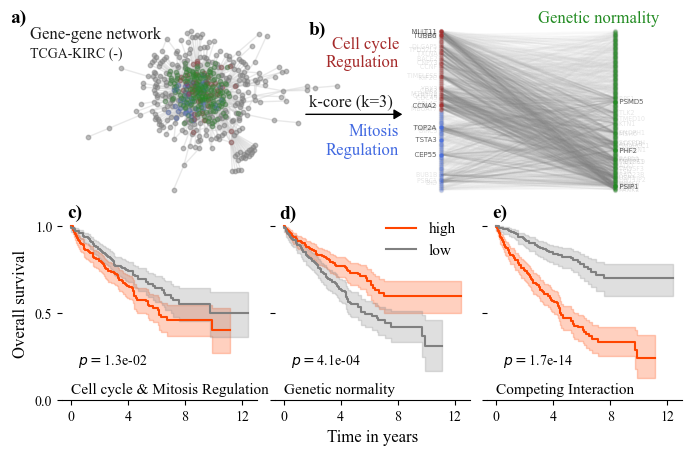

In [12]:
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
from matplotlib.patches import FancyArrowPatch

plt.rcParams["font.family"] = "Times New Roman"


label_dict = {
    'X': 'Cell cycle & Mitosis Regulation',
    'Y': 'Genetic normality',
    'int': 'Competing Interaction'
}
clr_list = ['royalblue', 'brown', 'forestgreen']
bipartite_labels = {
    'Mitosis\nRegulation': [-1.35, -0.3, 'right'],
    'Cell cycle\nRegulation': [-1.35, 0.3, 'right'],
    'Genetic normality': [-0.2, 0.6, 'left'],
}

# Create a figure
fig = plt.figure(figsize=(8, 5))

### Top row
ax1 = plt.subplot2grid((2, 6), (0, 0), colspan=3)
ax2 = plt.subplot2grid((2, 6), (0, 3), colspan=3)

nx.draw(G_cc, pos=layout_G_cc, ax=ax1, node_size=10, node_color='gray', edge_color='lightgray', alpha=0.5)
for i, com in enumerate(coms_X + [Y]):
    nx.draw(G_cc, pos=layout_G_cc, nodelist=com, edgelist=[], ax=ax1, node_size=10, node_color=clr_list[i], alpha=0.2)
#nx.draw(G_cc, pos=layout_G_cc, nodelist=list(X)+list(Y), ax=ax1, node_size=10, node_color='k', edge_color='lightgray', alpha=0.5)

nx.draw(G, pos=layout_G_bi, ax=ax2, node_size=10, node_color='gray', edge_color='lightgray', alpha=0.1)
nx.draw(G, pos=layout_G_bi, nodelist=[], edgelist=G_10.edges, ax=ax2, node_size=10, node_color='gray', edge_color='gray', alpha=0.1)

for i, com in enumerate(coms_X + [Y]):
    nx.draw(G, pos=layout_G_bi, nodelist=com, edgelist=[], ax=ax2, node_size=5, node_color=clr_list[i], alpha=0.2)
    
    nx.draw(G, pos=layout_G_bi, labels={g: f"  {g}  " for g in com if g in G_10.nodes}, nodelist=[g for g in com if g in G_10.nodes],
            edgelist=[], ax=ax2, node_size=5, node_color=clr_list[i], alpha=0.1, font_size=4.5, horizontalalignment='right' if i != 2 else 'left')
    
    highlight = [g[0] for g in sorted(G.degree, key=lambda x: x[1], reverse=True) if g[0] in com]
    highlight = highlight[::5][:3] if i ==2 else highlight[:3]
    print(highlight)
    nx.draw(G, pos=layout_G_bi, labels={g: f"  {g}  " for g in highlight if g in G.nodes and g in com}, nodelist=[g for g in highlight if g in G.nodes and g in com],
            edgelist=[], ax=ax2, node_size=5, node_color=clr_list[i], alpha=0.6, font_size=5, horizontalalignment='right' if i != 2 else 'left')


ax2.set_xlim(-1.5, 1)

for i, (name, values) in enumerate(bipartite_labels.items()):
    ax2.text(values[0], values[1], name, horizontalalignment=values[2], fontsize=12, color=clr_list[i])  

### Bottom row
ax3 = plt.subplot2grid((2, 6), (1, 0), colspan=2)
ax4 = plt.subplot2grid((2, 6), (1, 2), colspan=2)
ax5 = plt.subplot2grid((2, 6), (1, 4), colspan=2)

plt.setp(ax4.get_yticklabels(), visible=False)
plt.setp(ax5.get_yticklabels(), visible=False)

for ax, col in zip([ax3, ax4, ax5], ['X', 'Y', 'int']):

    group = data_plotting[col] > np.percentile(data_plotting[col], 50)
    group_names = ["low", "high"]  # for 0 and 1

    # PLOT KM
    T = data_plotting["time"]
    E = data_plotting["event"]

    kmf = KaplanMeierFitter()
    kmf.fit(T[group], event_observed=E[group], label=group_names[1])
    kmf.plot_survival_function(ax=ax, color="orangered")

    kmf = KaplanMeierFitter()
    kmf.fit(T[-group], event_observed=E[-group], label=group_names[0])
    kmf.plot_survival_function(ax=ax, color="gray")

    logrank = logrank_test(T[group], T[-group], E[group], E[-group])

    ax.set_ylim(0, 1.1)

    ax.spines["top"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["right"].set_visible(False)

    ax.text(0, 0.02, label_dict[col], fontsize=11, horizontalalignment='left', verticalalignment='bottom')
    if col == 'Y':
        ax.legend(fontsize=11, frameon=False, loc=1, alignment='right', ncols=1)
    else:
        ax.get_legend().remove()
    ax.set_yticks([0, 0.5, 1])

    ax.set_xlabel('', fontsize=10)

    YEAR = 365
    ax.set_xticks([i*YEAR for i in range(0, 16, 4)], list(range(0, 16, 4)))

    ax.text(0.5*YEAR, 0.2, f"$p =${logrank.p_value:.1e}")


ax4.set_xlabel('Time in years', fontsize=12)
ax3.set_ylabel('Overall survival', fontsize=12)

plt.subplots_adjust(hspace=0.01)

x1, y1 = ax1.transAxes.transform_point((0.8, 0.48)) # Middle right of ax1
x2, y2 = ax2.transAxes.transform_point((0.08, 0.48)) # Middle left of ax2

# Transform to figure coordinates
coordsA = fig.transFigure.inverted().transform_point((x1, y1))
coordsB = fig.transFigure.inverted().transform_point((x2, y2))

# Create the arrow
arrow = FancyArrowPatch(coordsA, coordsB, transform=fig.transFigure, 
                        arrowstyle='-|>,head_length=5,head_width=3', connectionstyle='arc3,rad=-0', 
                        color='k', lw=1)

# Add the arrow to the figure
fig.patches.append(arrow)
ax2.text(-1.4, 0.03, 'k-core (k=3)', horizontalalignment='right', alpha=0.9, fontsize=12)

ax1.text(-1.3, 0.5, 'Gene-gene network', horizontalalignment='left', color='k', alpha=0.9, fontsize=12, verticalalignment='top')
ax1.text(-1.3, 0.35, 'TCGA-KIRC (-)', horizontalalignment='left', color='k', alpha=0.9, fontsize=10, verticalalignment='top')

abcde_labels = {
    'a': [-1.45, 0.5],
    'b': [-2.1, 0.5],
    'c': [-100, 1.02],
    'd': [-100, 1.02],
    'e': [-100, 1.02],
}
for ax, (letter, coord) in zip([ax1, ax2, ax3, ax4, ax5], abcde_labels.items()):
    ax.text(coord[0], coord[1], f'{letter})', weight='bold', fontsize=14, va='bottom', ha='left')


fig.savefig('../figures/figure7_KIRC-competing-case-study.pdf', dpi=500, bbox_inches='tight', transparent=True)